In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from functools import partial
import random
#import cv2
from PIL import Image
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import copy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

#### Carregar as fotos
Carrega a foto, reescalona (resize) e retorna o seu formato em RGB.

In [5]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

#### Carregar os pixels RGB da imagem

retorna um DataFrame com as coordenadas RGB da imagem.

In [6]:
def pick_pixels(photo):
    n , m = photo.size
    ibagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            ibagem.append(list(pixels[i,j]))
    return pd.DataFrame(ibagem)

#### Colorir a imagem
Colore a imagem com as respectivas cores dos centroides. 

In [7]:
def coloring(photo, labels, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            numb = [int(number) for number in centers[labels[i*m + j]] ] 
            pixels[i,j]= tuple(numb)
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

### Carregar dados

In [8]:
def import_data():
    data = loadmat('fcm_dataset.mat')
    data = pd.DataFrame(data['x'])
    lendata = len(data)
    print('Numero de obervacoes: ', lendata)
    nfeatures = data.shape[1]
    print('Numero de atributos (features): ', nfeatures)

    return data.values#.transpose()

def reduc_samples(X,n_samples=10):
    return X[:n_samples, :]

def plot_samples(x, u, centroids):
    y_kmeans = np.argmax(u, axis=1)
    plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.show()

def plot_samples3D(x, u, centroids):
    y_ = np.argmax(u, axis=1)
    target_names = ['Red','Green','Blue']
    colors = ['navy', 'turquoise', 'darkorange']
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2], 
                c=y_, cmap='viridis',
                edgecolor='k', s=40, alpha = 0.5)


    ax.set_title("RGB information Fuzzy Kmeans")
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    ax.dist = 10

    for cent in centroids:
        ax.scatter(cent, 
               s = 300, c = 'r', marker='*', label = 'Centroid')

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()

#### Algoritmo Fuzzy K means

In [23]:
def generate_u(k: int, n: int):
    return np.random.dirichlet(np.ones(k), size=n)


# returns array of K centroids
def calc_centroids(U, X, m):
    centroids = []
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    for i in range(n_centroids):
        u_i = U[:,i] 
        ui_m = u_i ** m

        features_cent = []
        n_feat_cent = int(X.shape[1])
        for feat in range(n_feat_cent):
            x_feat = X[:,feat]
            feat_cent = np.sum((ui_m*x_feat))/np.sum(ui_m) 
            features_cent.append(feat_cent)
        centroids.append(features_cent)

    centroids = np.array(centroids)
    return centroids


def calc_cost(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    cost = 0

    for i in range(n_centroids):
        for j in range(n_samples):
            dist = distance.euclidean(centroids[i], X[j,:])
            cost += (U[j][i] ** m) * (dist ** 2)

    return cost


def update_u(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    U_new = copy.copy(U)

    for j in range(n_samples):
        dist_kj = 0
        for k in range(n_centroids):
            dist_kj += distance.euclidean(centroids[k], X[j,:])
        for i in range(n_centroids):
            dist_ij = distance.euclidean(centroids[i], X[j,:])
            U_new[j][i] = 1 / (dist_ij / dist_kj) ** (2/(m - 1))
        #normaliza valores entre 0 e 1 para cada amostra
        sum_ = np.sum(U_new[j])
        U_new[j] = U_new[j]/sum_
    
    return U_new

# x: dataset composto de pontos no plano cartesiano (número de dimensões arbitrário)
# n_centroides: número desejado de clusters
# m: exponente de peso
def fuzzy_k_means(x, n_centroides, m, threshold = 0.001, max_inter = 10, plot='no'):
    if m <= 1:
        raise Exception(" 'm' should be greater than 1")

    u = generate_u(n_centroides, x.shape[0])
    cost = 1
    centroids = []
    iterations = 0

    while cost > threshold and iterations < max_inter:
        print('Interação {}'.format(iterations+1))
        centroids = calc_centroids(u, x, m)
        cost = calc_cost(u, x, centroids, m)
        u = update_u(u, x, centroids, m)
        iterations += 1
        print('Erro : {}'.format(cost))
        print('Matrix centroids: {}'.format(centroids))
        print('Matrix U: {}'.format(u))
        if plot == '2D':
            plot_samples(x, u, centroids)
        elif plot == '3D':
            plot_samples3D(x, u, centroids)

    
    return {'centroids': centroids, 'u_matrix': u, 'n_iterations': iterations}

Numero de obervacoes:  800
Numero de atributos (features):  2
Interação 0
Erro : 202.33161759500604
Matrix centroids: [[3.25416554 4.25623705]
 [3.24129021 4.2293433 ]
 [3.29994969 4.2898943 ]
 [3.23607459 4.22260555]]
Matrix U: [[0.25035542 0.23870759 0.27553091 0.23540608]
 [0.25043982 0.23471142 0.28445576 0.230393  ]
 [0.24984849 0.23701664 0.27983879 0.23329608]
 ...
 [0.24984177 0.26266485 0.22026956 0.26722382]
 [0.24987612 0.2624101  0.22084811 0.26686567]
 [0.25039259 0.26125843 0.22312795 0.26522103]]


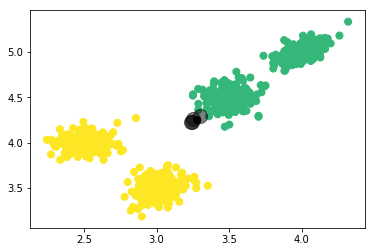

Interação 1
Erro : 125.59272180771845
Matrix centroids: [[3.25289823 4.25110908]
 [3.18727061 4.17770983]
 [3.38488571 4.37846551]
 [3.1674342  4.15669739]]
Matrix U: [[0.24603115 0.2099383  0.34317984 0.20085071]
 [0.24077334 0.19524021 0.37965078 0.18433567]
 [0.24354887 0.2032007  0.36002758 0.19322285]
 ...
 [0.23526158 0.29105016 0.16268048 0.31100778]
 [0.2357607  0.29031336 0.16417693 0.30974901]
 [0.2382562  0.28725219 0.17022955 0.30426205]]


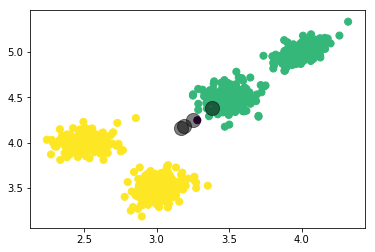

Interação 2
Erro : 109.88571716464473
Matrix centroids: [[3.24493904 4.24026403]
 [3.03109774 4.02051588]
 [3.52595955 4.52163954]
 [2.98281599 3.97068257]]
Matrix U: [[0.22532965 0.1432827  0.50039344 0.13099421]
 [0.19286467 0.10770821 0.60307191 0.09635521]
 [0.21115782 0.12634426 0.54817749 0.11432043]
 ...
 [0.16456473 0.34416509 0.07852996 0.41274022]
 [0.16688111 0.34295247 0.08068866 0.40947776]
 [0.18031926 0.33802643 0.09129779 0.39035652]]


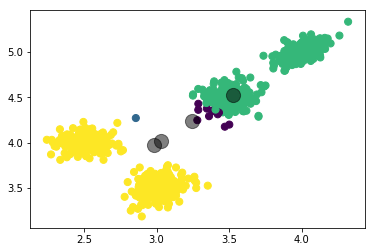

Interação 3
Erro : 78.26175792131853
Matrix centroids: [[3.35866577 4.35122875]
 [2.84733653 3.83565846]
 [3.65003511 4.64661908]
 [2.81067861 3.79787647]]
Matrix U: [[0.22679348 0.07918981 0.61932677 0.07468994]
 [0.15906606 0.04105216 0.76161835 0.03826343]
 [0.19661392 0.05948554 0.68811478 0.05578576]
 ...
 [0.07624996 0.42295684 0.0386675  0.4621257 ]
 [0.07845867 0.42055482 0.0402039  0.46078261]
 [0.09951797 0.41060034 0.05266304 0.43721865]]


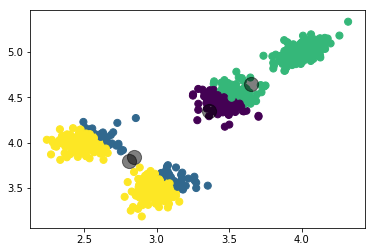

Interação 4
Erro : 52.756012536471935
Matrix centroids: [[3.47289375 4.46764568]
 [2.77675558 3.76669353]
 [3.82260816 4.8227793 ]
 [2.76539757 3.75435492]]
Matrix U: [[0.15125215 0.03381254 0.78172073 0.03321459]
 [0.0485787  0.00677205 0.9380199  0.00662935]
 [0.09077315 0.01626581 0.87700874 0.0159523 ]
 ...
 [0.05285863 0.45813824 0.02597453 0.4630286 ]
 [0.0543687  0.45634455 0.02696536 0.46232139]
 [0.07330505 0.44297564 0.03727525 0.44644405]]


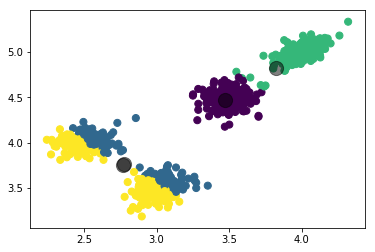

Interação 5
Erro : 34.3856547722004
Matrix centroids: [[3.48721048 4.48049953]
 [2.75953465 3.7511263 ]
 [3.97543097 4.97948469]
 [2.75746129 3.74623512]]
Matrix U: [[0.03913301 0.008172   0.94456593 0.00812906]
 [0.08920809 0.0113206  0.88822244 0.01124886]
 [0.01016431 0.00167996 0.98648514 0.0016706 ]
 ...
 [0.05078863 0.46630067 0.02007615 0.46283455]
 [0.05216339 0.46496579 0.02085334 0.46201748]
 [0.07103368 0.45122229 0.0292287  0.44851532]]


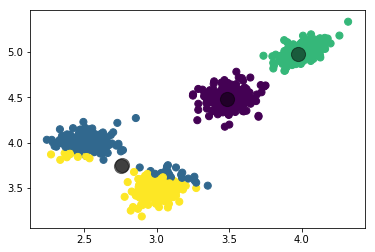

Interação 6
Erro : 32.190695589339335
Matrix centroids: [[3.48796205 4.48110772]
 [2.75492188 3.75039868]
 [3.99712488 5.00008769]
 [2.75905434 3.74431476]]
Matrix U: [[0.0284631  0.00590787 0.95973142 0.0058976 ]
 [0.11257416 0.01417557 0.85910857 0.0141417 ]
 [0.01130535 0.00185512 0.9849868  0.00185273]
 ...
 [0.05063784 0.47365589 0.01941316 0.45629311]
 [0.05199819 0.47224261 0.02016612 0.45559307]
 [0.07088578 0.45714647 0.02830965 0.4436581 ]]


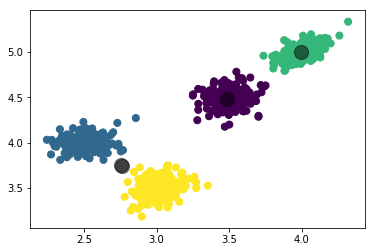

Interação 7
Erro : 32.14793095629239
Matrix centroids: [[3.48856976 4.48173348]
 [2.74755916 3.75687019]
 [3.99970621 5.00234899]
 [2.76633038 3.73785856]]
Matrix U: [[0.02742607 0.00567935 0.96122227 0.0056723 ]
 [0.11576377 0.01453372 0.85520755 0.01449496]
 [0.01164655 0.00190416 0.98454342 0.00190587]
 ...
 [0.05040019 0.49792386 0.01927858 0.43239737]
 [0.05176693 0.49572428 0.02003147 0.43247732]
 [0.070652   0.47605843 0.02815269 0.42513688]]


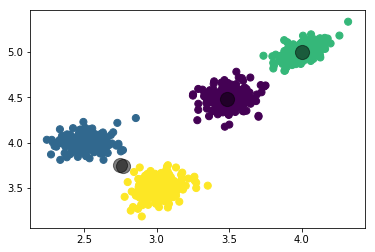

Interação 8
Erro : 31.865935734859924
Matrix centroids: [[3.4887657  4.48193662]
 [2.72197869 3.7818056 ]
 [4.00002564 5.00262415]
 [2.79202431 3.71291145]]
Matrix U: [[0.02731171 0.00565382 0.9613979  0.00563657]
 [0.11622565 0.01460422 0.8546825  0.01448764]
 [0.01169651 0.00190561 0.98448281 0.00191506]
 ...
 [0.04823899 0.5858256  0.0184521  0.34748331]
 [0.04969555 0.58070616 0.01923009 0.3503682 ]
 [0.06874538 0.54503454 0.02739274 0.35882734]]


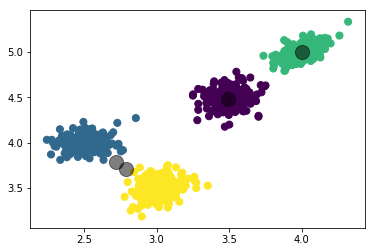

Interação 9
Erro : 28.56948461242043
Matrix centroids: [[3.48915092 4.48233773]
 [2.63973109 3.86272482]
 [4.00014506 5.00273964]
 [2.87542789 3.63157372]]
Matrix U: [[0.02729432 0.00562479 0.96151094 0.00556995]
 [0.11659363 0.01461814 0.85454853 0.0142397 ]
 [0.01173404 0.00188251 0.9844688  0.00191465]
 ...
 [0.02900908 0.83086134 0.01110458 0.12902501]
 [0.03106074 0.82011457 0.01202792 0.13679678]
 [0.05036372 0.7539705  0.02008199 0.17558379]]


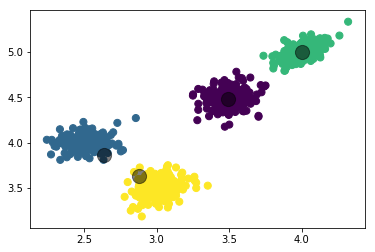

Interação 10
Erro : 15.76566409303355
Matrix centroids: [[3.49164758 4.48497025]
 [2.52910228 3.97010053]
 [4.00072718 5.00333617]
 [2.98754928 3.52310617]]
Matrix U: [[0.02725068 0.00547623 0.96188932 0.00538377]
 [0.11869033 0.01443196 0.85311707 0.01376064]
 [0.01195958 0.00183828 0.98430074 0.00190139]
 ...
 [0.00339823 0.98612529 0.00130743 0.00916905]
 [0.00501089 0.97952956 0.00195009 0.01350946]
 [0.0161172  0.94100184 0.00645687 0.03642409]]


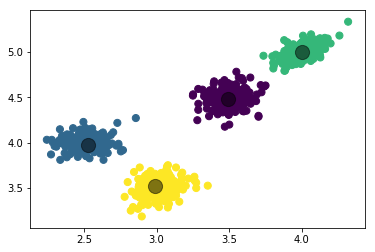

Interação 11
Erro : 12.47052363908519
Matrix centroids: [[3.49367267 4.48719364]
 [2.50417886 3.99017273]
 [4.00127952 5.00389842]
 [3.00991519 3.50177081]]
Matrix U: [[2.71799857e-02 5.38031198e-03 9.62139296e-01 5.30040669e-03]
 [1.20496211e-01 1.43583949e-02 8.51453570e-01 1.36918241e-02]
 [1.21628602e-02 1.83215123e-03 9.84096756e-01 1.90823235e-03]
 ...
 [1.33090762e-03 9.94846065e-01 5.14126718e-04 3.30890063e-03]
 [2.52963171e-03 9.90190100e-01 9.88381502e-04 6.29188701e-03]
 [1.05029873e-02 9.63188870e-01 4.22350606e-03 2.20846371e-02]]


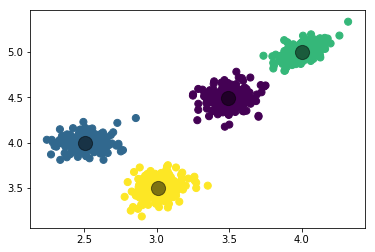

Interação 12
Erro : 12.433767355614995
Matrix centroids: [[3.49395006 4.48751575]
 [2.50150831 3.99155368]
 [4.00140778 5.00401746]
 [3.01181709 3.50000828]]
Matrix U: [[2.71504483e-02 5.36178262e-03 9.62200952e-01 5.28681680e-03]
 [1.20811086e-01 1.43506494e-02 8.51142103e-01 1.36961613e-02]
 [1.21980012e-02 1.83206179e-03 9.84059225e-01 1.91071212e-03]
 ...
 [1.18817739e-03 9.95417489e-01 4.59217078e-04 2.93511667e-03]
 [2.33463305e-03 9.90982537e-01 9.12633816e-04 5.77019585e-03]
 [1.00146293e-02 9.65017709e-01 4.02894902e-03 2.09387127e-02]]


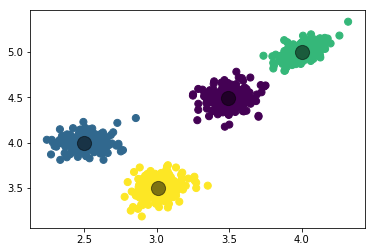

Interação 13
Erro : 12.433496790973734
Matrix centroids: [[3.49398354 4.48755697]
 [2.50123548 3.99163639]
 [4.00142962 5.00403686]
 [3.01196476 3.49988535]]
Matrix U: [[2.71445096e-02 5.35900034e-03 9.62211622e-01 5.28486829e-03]
 [1.20857089e-01 1.43503685e-02 8.51094395e-01 1.36981472e-02]
 [1.22030799e-02 1.83216353e-03 9.84053568e-01 1.91118901e-03]
 ...
 [1.17350789e-03 9.95475322e-01 4.53571360e-04 2.89759862e-03]
 [2.31430810e-03 9.91063489e-01 9.04735264e-04 5.71746788e-03]
 [9.96889586e-03 9.65185364e-01 4.01074088e-03 2.08349990e-02]]


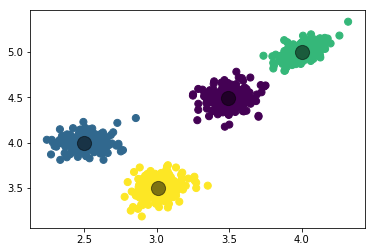

Interação 14
Erro : 12.433494550818255
Matrix centroids: [[3.49398793 4.48756251]
 [2.50120687 3.99164122]
 [4.00143299 5.0040398 ]
 [3.01197625 3.49987842]]
Matrix U: [[2.71435437e-02 5.35860943e-03 9.62213252e-01 5.28459449e-03]
 [1.20863722e-01 1.43504356e-02 8.51087300e-01 1.36985418e-02]
 [1.22038074e-02 1.83219166e-03 9.84052734e-01 1.91126706e-03]
 ...
 [1.17191896e-03 9.95481518e-01 4.52960088e-04 2.89360282e-03]
 [2.31210565e-03 9.91072130e-01 9.03879847e-04 5.71188494e-03]
 [9.96432630e-03 9.65201753e-01 4.00892506e-03 2.08249952e-02]]


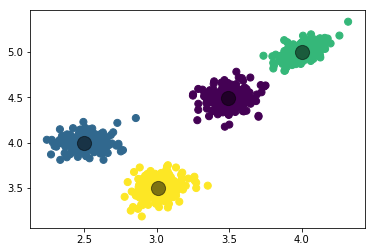

Interação 15
Erro : 12.43349452845927
Matrix centroids: [[3.49398855 4.48756329]
 [2.50120377 3.99164151]
 [4.00143349 5.00404023]
 [3.01197716 3.49987828]]
Matrix U: [[2.71433980e-02 5.35855528e-03 9.62213491e-01 5.28455578e-03]
 [1.20864687e-01 1.43504577e-02 8.51086248e-01 1.36986073e-02]
 [1.22039128e-02 1.83219725e-03 9.84052611e-01 1.91127909e-03]
 ...
 [1.17174359e-03 9.95482195e-01 4.52892697e-04 2.89316824e-03]
 [2.31186250e-03 9.91073071e-01 9.03785558e-04 5.71128104e-03]
 [9.96384380e-03 9.65203444e-01 4.00873402e-03 2.08239780e-02]]


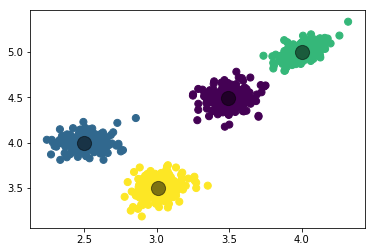

Interação 16
Erro : 12.433494528187445
Matrix centroids: [[3.49398865 4.48756341]
 [2.50120343 3.99164153]
 [4.00143356 5.00404029]
 [3.01197724 3.49987833]]
Matrix U: [[2.71433765e-02 5.35854772e-03 9.62213526e-01 5.28455021e-03]
 [1.20864829e-01 1.43504623e-02 8.51086091e-01 1.36986174e-02]
 [1.22039284e-02 1.83219824e-03 9.84052593e-01 1.91128090e-03]
 ...
 [1.17172389e-03 9.95482271e-01 4.52885140e-04 2.89312007e-03]
 [2.31183515e-03 9.91073175e-01 9.03774982e-04 5.71121439e-03]
 [9.96379049e-03 9.65203627e-01 4.00871304e-03 2.08238698e-02]]


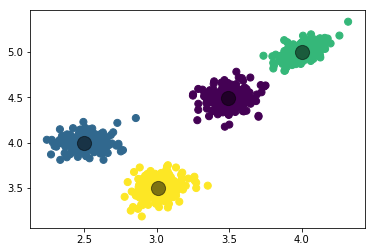

Interação 17
Erro : 12.433494528183527
Matrix centroids: [[3.49398866 4.48756343]
 [2.50120339 3.99164153]
 [4.00143358 5.0040403 ]
 [3.01197725 3.49987834]]
Matrix U: [[2.71433734e-02 5.35854665e-03 9.62213531e-01 5.28454939e-03]
 [1.20864851e-01 1.43504631e-02 8.51086067e-01 1.36986189e-02]
 [1.22039307e-02 1.83219841e-03 9.84052590e-01 1.91128117e-03]
 ...
 [1.17172164e-03 9.95482279e-01 4.52884279e-04 2.89311463e-03]
 [2.31183202e-03 9.91073187e-01 9.03773776e-04 5.71120690e-03]
 [9.96378439e-03 9.65203647e-01 4.00871066e-03 2.08238579e-02]]


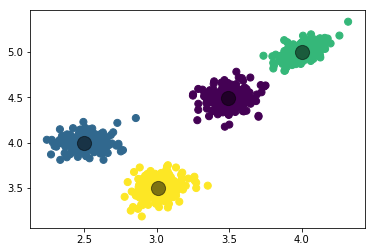

Interação 18
Erro : 12.433494528183463
Matrix centroids: [[3.49398867 4.48756343]
 [2.50120339 3.99164153]
 [4.00143358 5.0040403 ]
 [3.01197725 3.49987834]]
Matrix U: [[2.71433729e-02 5.35854650e-03 9.62213531e-01 5.28454927e-03]
 [1.20864854e-01 1.43504633e-02 8.51086064e-01 1.36986192e-02]
 [1.22039310e-02 1.83219843e-03 9.84052589e-01 1.91128121e-03]
 ...
 [1.17172137e-03 9.95482280e-01 4.52884180e-04 2.89311401e-03]
 [2.31183166e-03 9.91073189e-01 9.03773637e-04 5.71120604e-03]
 [9.96378367e-03 9.65203649e-01 4.00871039e-03 2.08238566e-02]]


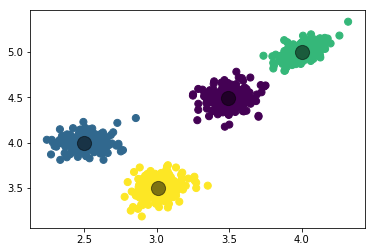

Interação 19
Erro : 12.433494528183456
Matrix centroids: [[3.49398867 4.48756343]
 [2.50120339 3.99164153]
 [4.00143358 5.0040403 ]
 [3.01197725 3.49987834]]
Matrix U: [[2.71433729e-02 5.35854647e-03 9.62213531e-01 5.28454925e-03]
 [1.20864855e-01 1.43504633e-02 8.51086063e-01 1.36986192e-02]
 [1.22039311e-02 1.83219844e-03 9.84052589e-01 1.91128122e-03]
 ...
 [1.17172134e-03 9.95482281e-01 4.52884168e-04 2.89311394e-03]
 [2.31183161e-03 9.91073189e-01 9.03773620e-04 5.71120594e-03]
 [9.96378359e-03 9.65203650e-01 4.00871035e-03 2.08238564e-02]]


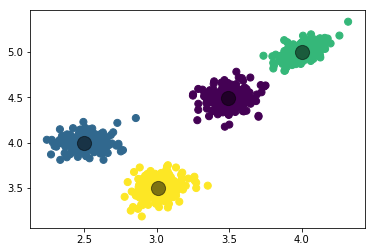

Resultado
Centroides: [[3.49398867 4.48756343]
 [2.50120339 3.99164153]
 [4.00143358 5.0040403 ]
 [3.01197725 3.49987834]]
Número de interações: 20
Matriz U: [[2.71433729e-02 5.35854647e-03 9.62213531e-01 5.28454925e-03]
 [1.20864855e-01 1.43504633e-02 8.51086063e-01 1.36986192e-02]
 [1.22039311e-02 1.83219844e-03 9.84052589e-01 1.91128122e-03]
 ...
 [1.17172134e-03 9.95482281e-01 4.52884168e-04 2.89311394e-03]
 [2.31183161e-03 9.91073189e-01 9.03773620e-04 5.71120594e-03]
 [9.96378359e-03 9.65203650e-01 4.00871035e-03 2.08238564e-02]]


In [24]:
X = import_data()
result = fuzzy_k_means(X, 4, 2, 0.1, 20, plot = '2D')
print('Resultado')
print('Centroides: {}'.format(result['centroids']))
print('Número de interações: {}'.format(result['n_iterations']))
print('Matriz U: {}'.format(result['u_matrix']))

### Exemplo de Fluxo de Execução
Isto deve ser feito para cada imagem

In [34]:
filename = './../ImagensTeste/photo001.jpg'
# código exemplo

photo = photo_open(filename)
pixels = pick_pixels(photo).values
print(pixels.shape)
plt.figure('Pixels RGB da imagem', figsize=(7,5))
ax = plt.axes(projection = '3d')
ax.scatter(pixels[:,2],pixels[:,1],pixels[:,0])
plt.show()

(273280, 3)


KeyboardInterrupt: 

In [26]:
result = fuzzy_k_means(X, 4, 2, 0.1, 1, plot = '3D')


# labels, centers = KMeans(k = 4)     ....  chama o KMeans ou Fuzzy-CMeans
#photo = coloring(photo, labels, centers)

Interação 0


KeyboardInterrupt: 